In [1]:
from matplotlib import pyplot as plt
%matplotlib inline


import numpy as np
import time
import GPflow
import numpy as np
import time
import cPickle as pickle
import assigngp_dense
import VBHelperFunctions
import mouseQPCRModelSelection
import GPy

In [7]:
import pods
g = 'Runx1'
print  'Load gene expression'
data = pods.datasets.singlecell()
genes = data['Y']  
Yg = genes[g].values[:,None]    
Yall =  genes.values    
t0=time.time()  
N = Yall.shape[0]
labels = data['labels']
stageCell = np.zeros(N)
stageN = np.zeros(N)
for i,l in enumerate(labels):
    stageCell[i] = int(l[:2])
    stageN[i] = np.log2(stageCell[i]) + 1
    
#pt = stageN

Load gene expression


In [3]:
def plotGene(t,g,labels):
    import matplotlib.cm as cm
    labelLegend = np.unique(labels)
    with plt.style.context('seaborn-whitegrid'):
        colors = cm.spectral(np.linspace(0, 1, len(labelLegend)))
        plt.figure(figsize=(10, 10))
        for lab,c in zip(labelLegend,colors):
            y1 = t[labels == lab]
            y2 = g[labels == lab]
            plt.scatter(y1,y2,label=lab, c=c,s=80)
            plt.text(np.median(y1),np.median(y2),lab, fontsize=45, color='blue')
        plt.legend(loc='upper left')

(437, 2)
(437, 2)
[-2. -2. -2. -2. -2. -2. -2. -2. -2. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  0.  0.]
[-2. -2. -2. -2. -2. -2. -2. -2. -2. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  0.  0.]


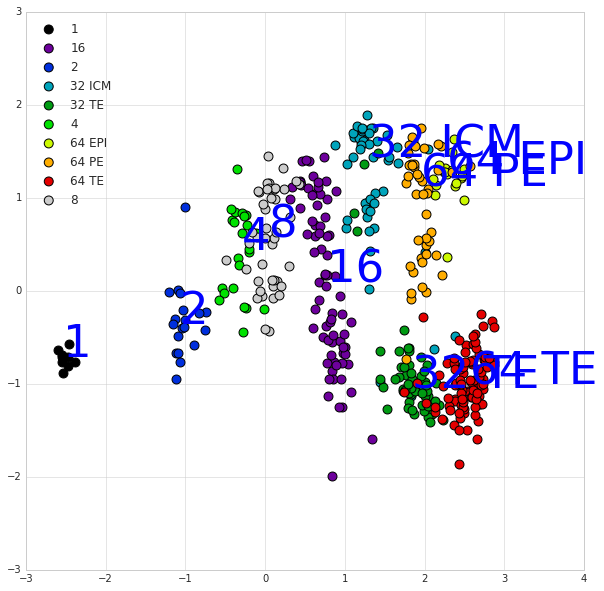

In [13]:
# GPLVM with capture times
# Additive kernel
import GPy
ct = stageN-3

k1=GPy.kern.Matern32(1,active_dims=[0]) # AB Change
k2=GPy.kern.Matern32(1,active_dims=[1]) #AB change

priormean=np.hstack([np.expand_dims(ct,1),np.zeros( (N,1))])
priorstd= 0.1*np.ones((N,2))

print priormean.shape
print priorstd.shape

np.random.seed(0)
# import GPy.util.initialization import initialize_latent
Xinit, varX = GPy.util.initialization.initialize_latent('PCA', 2, Yall)
# draw from prior for initial condition? PCA is not a good initialisation because it messes up ordering
for i in range(N):
    Xinit[i,0] = priormean[i,0] + priorstd[i,0]*np.random.randn(1)
    
print ct[:30]
print np.round(Xinit[:30,0])

time_kernel = k1+k2
time_model = GPy.models.BayesianGPLVM(Yall, 2, kernel=time_kernel, X=Xinit )

for i in range(N):
    time_model.X.mean[i, [0]].set_prior(GPy.priors.Gaussian(ct[i], 1), warning=False)

time_model.likelihood.fix(Yall.std()/100)
time_model.optimize(messages=1, max_iters=100)
time_model.likelihood.unfix()
time_model.optimize(messages=1)    

plotGene(time_model.X.mean.values[:,0], genes['Id2'].values, labels)

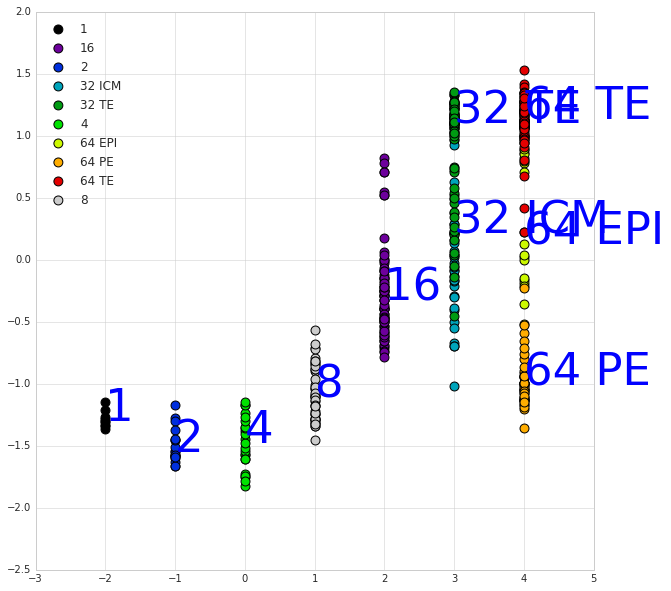

In [23]:
plotGene(ct, genes['Gata4'].values, labels)

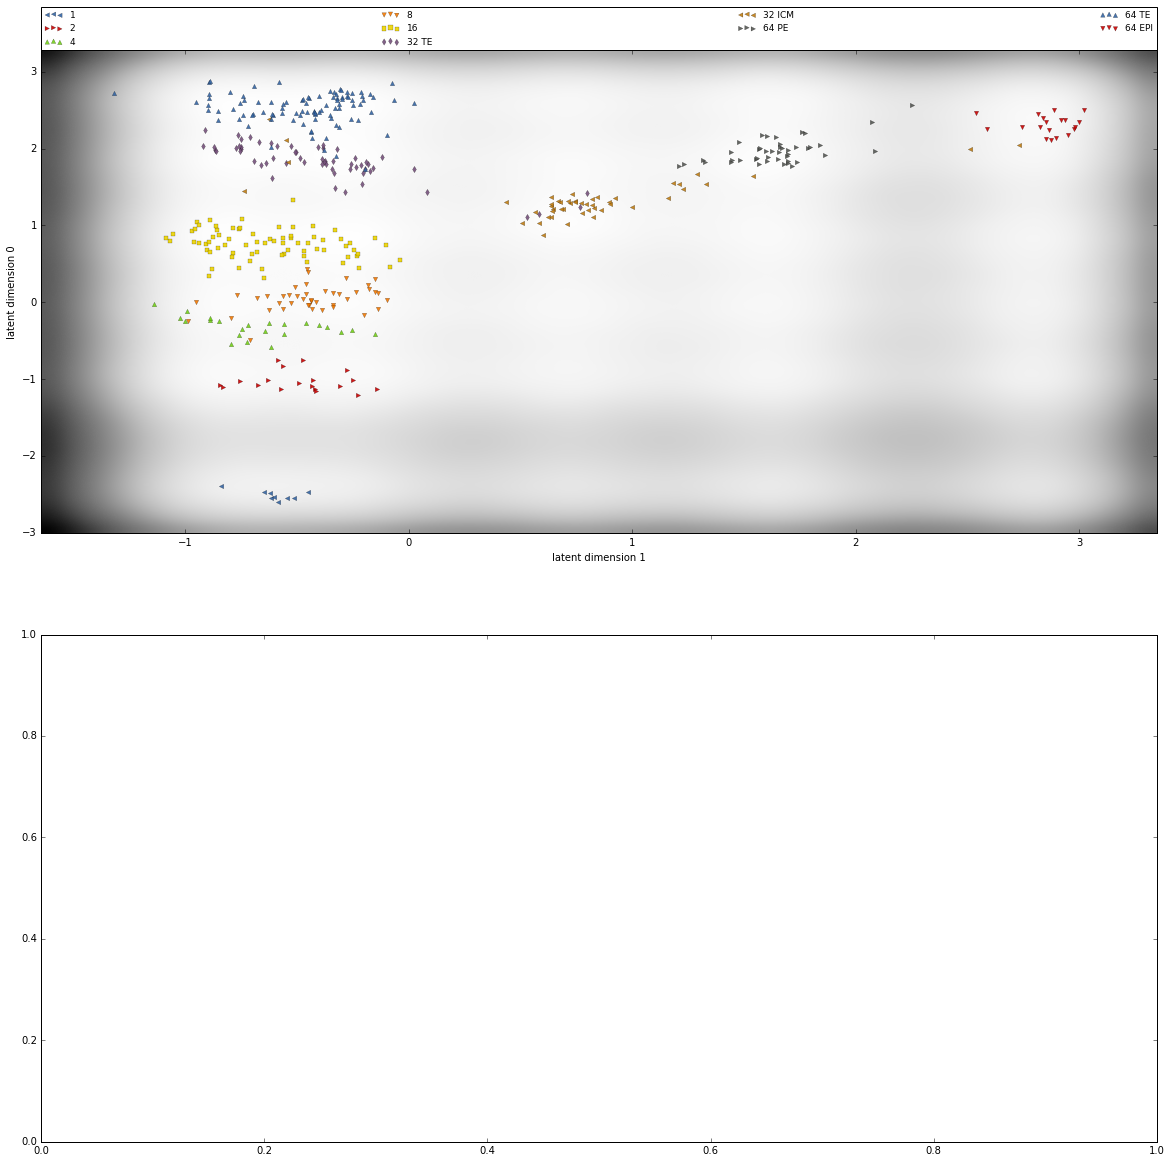

In [15]:
fig, (latent_axes, sense_axes) = plt.subplots(2, 1, figsize=(20,20))
time_model.plot_latent(ax=latent_axes, labels=labels)

pt = time_model.X.mean.values[:,0]

In [16]:
from GPclust import OMGP


('\riteration 1 bound=-18416.5192477 grad=3647.73602246, beta=0',)
('\riteration 2 bound=-18175.6813122 grad=7498.88702474, beta=1.5948484949',)
('\riteration 3 bound=-16338.3690702 grad=32568.0701931, beta=2.21626940121',)
('\riteration 4 bound=-11183.9400172 grad=202598.216042, beta=2.297933863',)
('\riteration 5 bound=-9151.91316465 grad=204704.119734, beta=3.6654596231',)
('\riteration 6 bound=-8779.67174372 grad=40841.0328277, beta=0.0',)
('\riteration 7 bound=-8438.56640527 grad=27048.0513823, beta=0.311877082577',)
('\riteration 8 bound=-8221.91631169 grad=21916.060207, beta=0.0',)
('\riteration 9 bound=-8046.09823646 grad=17624.1712786, beta=0.0',)
('\riteration 10 bound=-7890.74771419 grad=14897.617665, beta=0.0',)
('\riteration 11 bound=-7745.90334739 grad=13551.2552894, beta=0.0',)
('\riteration 12 bound=-7606.48214626 grad=12984.148658, beta=0.0',)
('\riteration 13 bound=-7473.17010353 grad=12529.3957858, beta=0.0',)
('\riteration 14 bound=-7342.77731965 grad=12241.6611669,

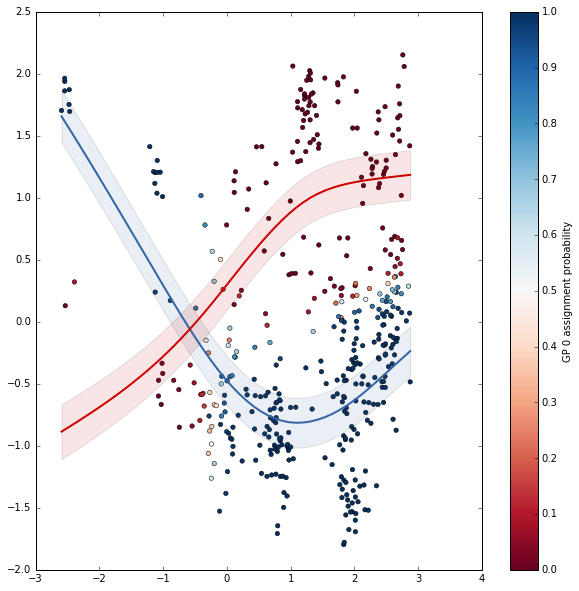

In [21]:
l = pt.min() + 1
u = pt.max() - 1
    
kernOMGP_1=GPy.kern.Matern32(1) # AB Change
kernOMGP_2=GPy.kern.Matern32(1) # AB Change

m = OMGP(pt[:,None], Yg, K=2, variance=0.01, kernels=[kernOMGP_1, kernOMGP_2] , prior_Z='DP') # use a truncated DP with K=2
m.kern[0].lengthscale = 10*(u-l)
m.kern[1].lengthscale = 10*(u-l)
m.optimize(step_length=0.01, maxiter=20)
fig=plt.figure(figsize=(10,10))
m.plot()

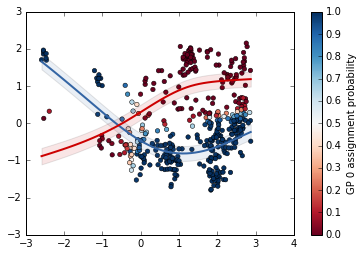

In [24]:
fig
m.plot()

('\riteration 1 bound=-4737.83211486 grad=7188.17415847, beta=0',)
('\riteration 2 bound=-4677.73562758 grad=7405.97080236, beta=0.0',)
('\riteration 3 bound=-4615.81809248 grad=7350.81323023, beta=0.0',)
('\riteration 4 bound=-4551.05823983 grad=7886.81190256, beta=0.0',)
('\riteration 5 bound=-4484.05803633 grad=8041.84525936, beta=0.0',)
('\riteration 6 bound=-4415.03411124 grad=8552.49366476, beta=0.0',)
('\riteration 7 bound=-4345.56409907 grad=8534.54679787, beta=0.0',)
('\riteration 8 bound=-4276.48356004 grad=8749.80034319, beta=0.0',)
('\riteration 9 bound=-4208.60769063 grad=8504.63983278, beta=0.0',)
('\riteration 10 bound=-4141.54151995 grad=8628.57696406, beta=0.0',)
('\riteration 11 bound=-4074.16192881 grad=8455.52368039, beta=0.0',)
('\riteration 12 bound=-4006.10087504 grad=8716.16495843, beta=0.0',)
('\riteration 13 bound=-3936.33253801 grad=8724.72318623, beta=0.0',)
('\riteration 14 bound=-3865.88218405 grad=9037.56750413, beta=0.0',)
('\riteration 15 bound=-3794.69

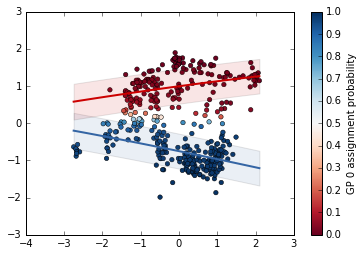

In [30]:
m.optimize(step_length=0.01, maxiter=100)
m.plot()

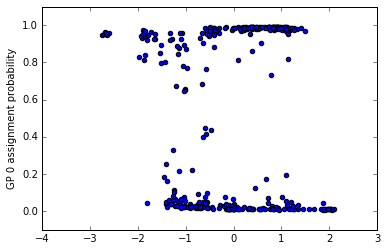

In [31]:
m.plot_probs()

In [9]:
m

OMGP.,value,constraints,priors
variance,0.0548512508579,+ve,
rbf.variance,23.8906548653,+ve,
rbf.lengthscale,63.6336450783,+ve,
rbf_1.variance,70.2669809069,+ve,
rbf_1.lengthscale,60.9617790726,+ve,


# VB Branching code

In [10]:
import BranchingTree as bt
import branch_kernParamGPflow as bk
def InitModels(pt, XExpanded, Y):
    # code that's a bit crappy - we dont need this
    tree = bt.BinaryBranchingTree(0,90,fDebug=False) # set to true to print debug messages
    tree.add(None,1,10) # single branching point
    (fm, _) = tree.GetFunctionBranchTensor()
    #KbranchVB = bk.BranchKernelParam(GPflow.kernels.RBF(1), fm, BvInitial=np.ones((1,1))) + GPflow.kernels.White(1) 
    KbranchVB = bk.BranchKernelParam(GPflow.kernels.RBF(1), fm, BvInitial=np.ones((1,1))) + GPflow.kernels.White(1) + GPflow.kernels.Linear(1) + GPflow.kernels.Constant(1) # other copy of kernel
    KbranchVB.branchkernelparam.Bv.fixed = True
    mV = assigngp_dense.AssignGP(pt, XExpanded, Y, KbranchVB)
    mV.kern.white.variance = 1e-6
    mV.kern.white.variance.fixed = True
    mV._compile() # creates objective function
    return mV

In [11]:
phiInitial, phiInitial_invSoftmax, XExpanded = VBHelperFunctions.InitialisePhiFromOMGP(None, phiOMGP=m.phi, b=0, Y=Yg,pt=pt)   
mV = InitModels(pt,XExpanded,Yg) # also do gene by gene

compiling tensorflow function...
done


In [12]:
mV

Name,values,prior,constriant
model.likelihood.variance,[ 1.],None,+ve
model.kern.branchkernelparam.kern.lengthscales,[ 1.],None,+ve
model.kern.branchkernelparam.kern.variance,[ 1.],None,+ve
model.kern.branchkernelparam.Bv,[[ 1.]],None,[FIXED]
model.kern.white.variance,[ 1.00000000e-06],None,[FIXED]
model.kern.linear.variance,[ 1.],None,+ve
model.kern.constant.variance,[ 1.],None,+ve
model.logPhi,"[[-0.81832523 0.20201616 -0.15169797 ..., -0.19281038 -1.39601815 0.60204163] [ 0.0774919 -1.61388818 0.36057485 ..., 0.8280142 0.23406377 -0.15177697] [-1.51886559 -0.17915838 -0.1028241 ..., 0.81242563 -1.07228617 -0.17389422] ..., [-0.41712579 -0.82985657 0.20853602 ..., 1.0161647 -1.72015934 0.64928185] [-0.28692723 -1.64443445 0.65175379 ..., 1.00634976 -0.76344221 1.13465652] [-1.83704873 -0.25769245 -0.20548676 ..., 0.87395845 0.10040612 -0.95562424]]",None,(none)


In [13]:
m

OMGP.,value,constraints,priors
variance,0.0548512508579,+ve,
rbf.variance,23.8906548653,+ve,
rbf.lengthscale,63.6336450783,+ve,
rbf_1.variance,70.2669809069,+ve,
rbf_1.lengthscale,60.9617790726,+ve,


2.8534128240986369

In [14]:
# Initialise all model parameters using the OMGP model
# Note that the OMGP model has different kernel hyperparameters for each latent function whereas the branching model
# has one common set.
mV.logPhi = phiInitial_invSoftmax # initialise allocations from OMGP
mV.likelihood.variance = m.variance.values[0]
# set lengthscale to maximum
mV.kern.branchkernelparam.kern.lengthscales = np.max(np.array([m.rbf.lengthscale.values, m.rbf_1.lengthscale.values]))
# set process variance to average
mV.kern.branchkernelparam.kern.variance = np.mean(np.array([m.rbf.variance.values, m.rbf_1.variance.values]))
mV

Name,values,prior,constriant
model.likelihood.variance,[ 0.05485125],None,+ve
model.kern.branchkernelparam.kern.lengthscales,[ 63.63364508],None,+ve
model.kern.branchkernelparam.kern.variance,[ 47.07881789],None,+ve
model.kern.branchkernelparam.Bv,[[ 1.]],None,[FIXED]
model.kern.white.variance,[ 1.00000000e-06],None,[FIXED]
model.kern.linear.variance,[ 1.],None,+ve
model.kern.constant.variance,[ 1.],None,+ve
model.logPhi,"[[ -1.99995576e-12 -2.76310211e+01 -2.76310211e+01 ..., -9.00000000e+00 -9.00000000e+00 -9.00000000e+00] [ -9.00000000e+00 -9.00000000e+00 -9.00000000e+00 ..., -9.00000000e+00 -9.00000000e+00 -9.00000000e+00] [ -9.00000000e+00 -9.00000000e+00 -9.00000000e+00 ..., -9.00000000e+00 -9.00000000e+00 -9.00000000e+00] ..., [ -9.00000000e+00 -9.00000000e+00 -9.00000000e+00 ..., -9.00000000e+00 -9.00000000e+00 -9.00000000e+00] [ -9.00000000e+00 -9.00000000e+00 -9.00000000e+00 ..., -9.00000000e+00 -9.00000000e+00 -9.00000000e+00] [ -9.00000000e+00 -9.00000000e+00 -9.00000000e+00 ..., -2.76310211e+01 -4.02948830e+00 -1.79434527e-02]]",None,(none)


In [15]:
def FlattenPhi(mV):
    # return flattened and rounded Phi i.e. N X 3
    phiFlattened = np.zeros((mV.Y.shape[0],3)) # only single branching point
    Phi = np.round(np.exp(mV.logPhi._array),decimals=4)
    f=2 # which function to plot phi against - can be 1,2 or 3
    iterC=0
    for i,p in enumerate(mV.t):
        phiFlattened[i,:] = Phi[i,iterC:iterC+3] 
        iterC+=3
    return phiFlattened
Phi=FlattenPhi(mV)

In [16]:
def plotVBCode(mV,figsizeIn=(20,10),lw=3.,fs=10):
    from matplotlib import cm
    D = mV.Y.shape[0]
    fig=plt.figure(figsize=figsizeIn)
    B=mV.kern.branchkernelparam.Bv._array.flatten()
    assert B.size == 1, 'Code limited to one branch point, got ' + str(B.shape)
    pt = mV.t
    l = np.min(pt)
    u = np.max(pt)
    d = 0 # constraint code to be 1D for now
    for f in range(1, 4):
        if(f == 1):
            ttest = np.linspace(l, B, 100)[:, None]  # root
        else:
            ttest = np.linspace(B, u, 100)[:, None]
        Xtest = np.hstack((ttest, ttest*0+f))
        mu, var = mV.predict_f(Xtest)
        assert np.all(np.isfinite(mu)), 'All elements should be finite but are ' + str(mu)
        assert np.all(np.isfinite(var)), 'All elements should be finite but are ' + str(var)
        mean, = plt.plot(ttest, mu[:, d], linewidth=lw)
        col = mean.get_color()
        plt.plot(ttest.flatten(), mu[:, d] + 2*np.sqrt(var.flatten()), '--', color=col, linewidth=lw)
        plt.plot(ttest, mu[:, d] - 2*np.sqrt(var.flatten()), '--', color=col, linewidth=lw)

    v = plt.axis()
    plt.plot([B, B], v[-2:], '-m',linewidth=lw)
    
    # could also plot phi
    Phi=FlattenPhi(mV)
    gp_num = 1 # can be 0,1,2 
    plt.scatter(pt, mV.Y[:,d], c=Phi[:, gp_num], vmin=0., vmax=1, s=40)
    plt.colorbar(label='GP {} assignment probability'.format(gp_num))


# Bayesian optimisation
1. Use GPyOpt to learn branching point and kernel hyperparameters.
1. set fixed=False for all parameters except for Phi.fixed=True
1. It's still beneficial to use *VB code* rather than *Jings model* since we integrate out (approximately using VB bound) uncertainty in allocation (Phi).
1. Store all intermediate values visited by GPyOpt?
1. Use Matern 3/2 or 5/2 for both OMGP and our model. Actually different kernels for OMGP and our can make sense as outputs different (potentially)?
1. Effect of Phi on inference of branching point?
1. add assert in VB code that before branching point, allocations probs==1 for 1st function.


In [17]:
import GPyOpt

In [18]:
# Objective function
class objectiveBAndK:
    def __init__(self, Binit):
        mV.kern.branchkernelparam.Bv.fixed = False # we wont optimize so this is fine
        mV.logPhi.fixed = False # allocations not fixed for GPyOpt because we update them for each branch point

        mV.likelihood.variance.fixed = False # all kernel parameters optimised
        mV.kern.branchkernelparam.kern.lengthscales.fixed = False
        mV.kern.branchkernelparam.kern.variance.fixed = False

        # initial branch point
        mV.kern.branchkernelparam.Bv = Binit
        VBHelperFunctions.InitialisePhiFromOMGP(mV, phiOMGP=m.phi, b=Binit, Y=Yg, pt=pt)  
        # Initialise all model parameters using the OMGP model 
        mV.likelihood.variance = m.variance.values[0]
        mV.kern.branchkernelparam.kern.lengthscales = np.max(np.array([m.rbf.lengthscale.values, m.rbf_1.lengthscale.values]))
        mV.kern.branchkernelparam.kern.variance = np.mean(np.array([m.rbf.variance.values, m.rbf_1.variance.values]))
        mV._compile()

    def f(self, theta):
        # theta is nxp array, return nx1
        n=theta.shape[0]
        VBboundarray = np.ones((n,1))
        for i in range(n):
            mV.kern.branchkernelparam.Bv = theta[i,0]
            VBHelperFunctions.InitialisePhiFromOMGP(mV, phiOMGP=m.phi, b=theta[i,0], Y=Yg, pt=pt)  
            mV.likelihood.variance = theta[i,1]
            mV.kern.branchkernelparam.kern.lengthscales = theta[i,2]
            mV.kern.branchkernelparam.kern.variance = theta[i,3]
            mV.kern.linear.variance = theta[i,4]
            mV.kern.constant.variance = theta[i,5]
            
            VBboundarray[i] = -mV.compute_log_likelihood() # we wish to minimize!
            print 'objectiveB B=%.0f likvar=%.0f len=%.0f var=%.0f VB=%.0f'%(theta[i,0], theta[i,1], theta[i,2], theta[i,3], VBboundarray[i] )
        return VBboundarray

In [19]:
# try optimisation
l = pt.min() + 1
u = pt.max() - 1
print l,u
# We need constraints on there parameters
# B = [l,u] 
# lik.variance > 0
# kern.lengthscale, variance > 0

# --- Optimize both B and K
myobj = objectiveBAndK(np.ones((1,1))*(l+u)/2) # pass in initial point - start at mid-point
eps = 1e-5
#bounds = [(l,u),(eps,3*Yg.var()), (eps,pt.max()), (eps,3*Yg.var())]  # B, lik var, len, var

bounds = [(l,u),(eps,3*Yg.var()), (eps,pt.max()), (eps,3*Yg.var()), [0.1,5], [0.1,5]]  # B, lik var, len, var, lin var, c var

BOobj = GPyOpt.methods.BayesianOptimization(f=myobj.f,  # function to optimize       
                                            bounds=bounds)              # normalized y                       
t0=time.time()
max_iter = 20 
import multiprocessing
n_cores = multiprocessing.cpu_count()

BOobj.run_optimization(max_iter,                             # Number of iterations
                       acqu_optimize_method = 'fast_random',        # method to optimize the acq. function
                       acqu_optimize_restarts = 30,
                       batch_method='lp',
                       n_inbatch = n_cores,                        # size of the collected batches (= number of cores)
                       eps = 1e-6)                                # secondary stop criteria (apart from the number of iterations) 

print 'GPyOpt took %g secs ' %(time.time()-t0)

-1.75300368478 1.10040913932
compiling tensorflow function...
done
objectiveB B=-0 likvar=2 len=2 var=2 VB=983
objectiveB B=-0 likvar=2 len=2 var=3 VB=994
objectiveB B=-0 likvar=0 len=1 var=0 VB=897
objectiveB B=0 likvar=2 len=1 var=1 VB=979
objectiveB B=0 likvar=2 len=2 var=1 VB=993
objectiveB B=-1 likvar=1 len=1 var=1 VB=899
objectiveB B=-0 likvar=1 len=1 var=3 VB=916
objectiveB B=-1 likvar=1 len=0 var=0 VB=898
objectiveB B=-1 likvar=1 len=2 var=2 VB=907
objectiveB B=1 likvar=0 len=1 var=2 VB=4470
objectiveB B=1 likvar=1 len=1 var=2 VB=887
objectiveB B=0 likvar=3 len=0 var=2 VB=1054
objectiveB B=-1 likvar=1 len=2 var=3 VB=901
objectiveB B=0 likvar=2 len=0 var=2 VB=962
objectiveB B=-0 likvar=0 len=2 var=1 VB=914
objectiveB B=0 likvar=1 len=1 var=3 VB=946
objectiveB B=0 likvar=1 len=1 var=1 VB=899
objectiveB B=-0 likvar=1 len=1 var=2 VB=944
objectiveB B=-1 likvar=3 len=0 var=3 VB=1114
objectiveB B=-2 likvar=2 len=1 var=1 VB=1037
objectiveB B=-2 likvar=3 len=2 var=1 VB=1093
objectiveB B

In [20]:
print 'Solution found by BO'
print BOobj.x_opt
print BOobj.fx_opt

# Can explicitly check computation using myobj.f(np.ones((1,1))*16.834)
# should add assert that Phi before branching point is 1 everywhere!

Solution found by BO
[-1.12078308  0.38747682  1.62491518  2.83175096  0.72691812  4.71200833]
[ 847.75716617]


Bound got 848.26 should be 847.76


Name,values,prior,constriant
model.likelihood.variance,[ 0.38747682],None,+ve
model.kern.branchkernelparam.kern.lengthscales,[ 1.62491518],None,+ve
model.kern.branchkernelparam.kern.variance,[ 2.83175096],None,+ve
model.kern.branchkernelparam.Bv,[[-1.12078308]],None,(none)
model.kern.white.variance,[ 1.00000000e-06],None,[FIXED]
model.kern.linear.variance,[ 5.],None,+ve
model.kern.constant.variance,[ 1.88685728],None,+ve
model.logPhi,"[[ -1.99995576e-12 -2.76310211e+01 -2.76310211e+01 ..., -9.00000000e+00 -9.00000000e+00 -9.00000000e+00] [ -9.00000000e+00 -9.00000000e+00 -9.00000000e+00 ..., -9.00000000e+00 -9.00000000e+00 -9.00000000e+00] [ -9.00000000e+00 -9.00000000e+00 -9.00000000e+00 ..., -9.00000000e+00 -9.00000000e+00 -9.00000000e+00] ..., [ -9.00000000e+00 -9.00000000e+00 -9.00000000e+00 ..., -9.00000000e+00 -9.00000000e+00 -9.00000000e+00] [ -9.00000000e+00 -9.00000000e+00 -9.00000000e+00 ..., -9.00000000e+00 -9.00000000e+00 -9.00000000e+00] [ -9.00000000e+00 -9.00000000e+00 -9.00000000e+00 ..., -2.76310211e+01 -4.02948830e+00 -1.79434527e-02]]",None,(none)


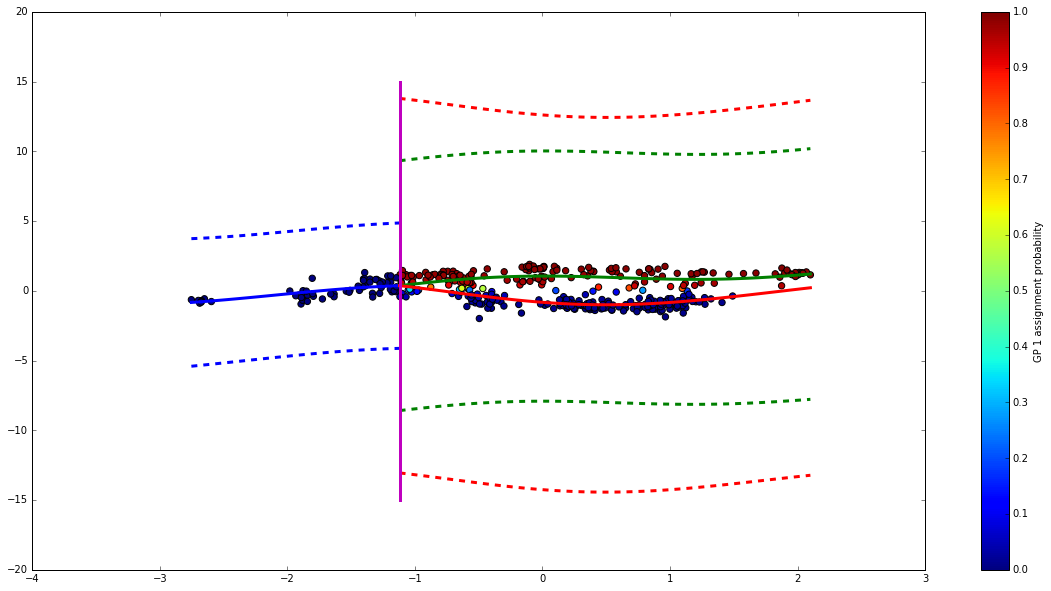

In [21]:
# plot best solution
mV.kern.branchkernelparam.Bv = BOobj.x_opt[0]
VBHelperFunctions.InitialisePhiFromOMGP(mV, phiOMGP=m.phi, b=BOobj.x_opt[0],Y=Yg,pt=pt)   
mV.likelihood.variance = BOobj.x_opt[1]
mV.kern.branchkernelparam.kern.lengthscales = BOobj.x_opt[2]
mV.kern.branchkernelparam.kern.variance = BOobj.x_opt[3]
print 'Bound got %.2f should be %.2f'%(-mV.compute_log_likelihood(), BOobj.fx_opt)
plotVBCode(mV)
mV

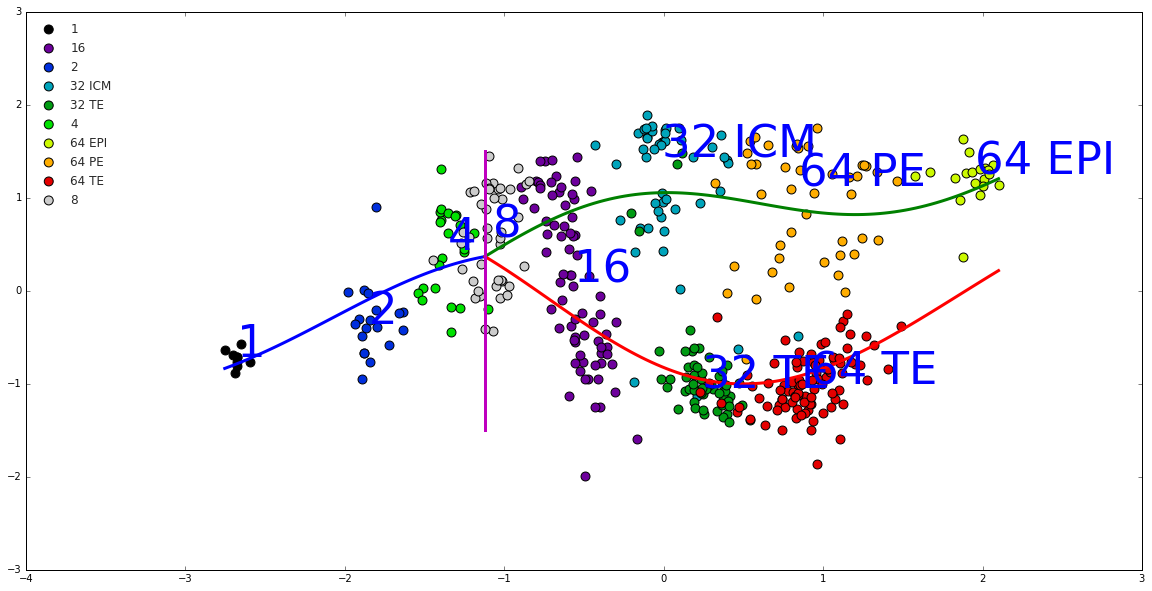

In [22]:
def plotVBCode(mV,figsizeIn=(20,10),lw=3.,fs=10,labels=None, fPlotPhi=True):
    import matplotlib.cm as cm
    from matplotlib import cm
    D = mV.Y.shape[0]
    fig=plt.figure(figsize=figsizeIn)
    B=mV.kern.branchkernelparam.Bv._array.flatten()
    assert B.size == 1, 'Code limited to one branch point, got ' + str(B.shape)
    pt = mV.t
    l = np.min(pt)
    u = np.max(pt)
    d = 0 # constraint code to be 1D for now
    for f in range(1, 4):
        if(f == 1):
            ttest = np.linspace(l, B, 100)[:, None]  # root
        else:
            ttest = np.linspace(B, u, 100)[:, None]
        Xtest = np.hstack((ttest, ttest*0+f))
        mu, var = mV.predict_f(Xtest)
        assert np.all(np.isfinite(mu)), 'All elements should be finite but are ' + str(mu)
        assert np.all(np.isfinite(var)), 'All elements should be finite but are ' + str(var)
        mean, = plt.plot(ttest, mu[:, d], linewidth=lw)
        col = mean.get_color()
        #plt.plot(ttest.flatten(), mu[:, d] + 2*np.sqrt(var.flatten()), '--', color=col, linewidth=lw)
        #plt.plot(ttest, mu[:, d] - 2*np.sqrt(var.flatten()), '--', color=col, linewidth=lw)

    v = plt.axis()
    plt.plot([B, B], v[-2:], '-m',linewidth=lw)
    
    # Plot Phi or labels
    if(fPlotPhi):
        Phi=FlattenPhi(mV)
        gp_num = 1 # can be 0,1,2 
        plt.scatter(pt, mV.Y[:,d], c=Phi[:, gp_num], vmin=0., vmax=1, s=40)
        plt.colorbar(label='GP {} assignment probability'.format(gp_num))
    elif(labels is not None):
        # plot labels
        labelLegend = np.unique(labels)
        with plt.style.context('seaborn-whitegrid'):
            colors = cm.spectral(np.linspace(0, 1, len(labelLegend)))
            for lab,c in zip(labelLegend,colors):
                y1 = pt[labels == lab]
                y2 = Yg[labels == lab]
                plt.scatter(y1,y2,label=lab, c=c,s=80)
                plt.text(np.median(y1),np.median(y2),lab, fontsize=45, color='blue')
            plt.legend(loc='upper left')
plotVBCode(mV,labels=labels,fPlotPhi=False)

In [94]:
.shape

(150, 7)